In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

!pip install diffrax

# Example: Lorenz System

Consider the Lorenz system of differential equations:

$$
\begin{align*}
\dot{x} &= \sigma(y-x),\\
\dot{y} &= x(\rho-z)-y,\\
\dot{z} &= xy-\beta z.
\end{align*}
$$

This system has a chaotic attractor for $\sigma=10$, $\beta=8/3$, and $\rho=28$.
We are going to study the sensitivity of the system on the initial conditions.
Our goal is to demonstrate that local sensitivity analysis **is not appropriate** for this system.

Let's code it up and see what it looks like.

In [110]:
import jax.numpy as jnp
from jax import vmap, jit
from functools import partial
from diffrax import diffeqsolve, Tsit5, ODETerm, SaveAt


def solve_lorenz(u0, theta):

    def vector_field(t, u, theta):
        x = u[0]
        y = u[1]
        z = u[2]
        sigma = theta[0]
        beta = theta[1]
        rho = theta[2]
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        return jnp.array([dx, dy, dz])

    return diffeqsolve(
        ODETerm(vector_field),
        Tsit5(),
        t0=0.0,
        t1=100.0,
        dt0=0.1,
        y0=u0,
        args=theta,
        saveat=SaveAt(ts=jnp.linspace(0.0, 100.0, 10_000))
    ).ys

In [112]:
monte_carlo_lorenz = jit(vmap(solve_lorenz, in_axes=(0, None)))

sigma = 10.0
beta = 8.0 / 3.0
rho = 28.0
theta = jnp.array([sigma, beta, rho])
u0 = jnp.array([1.0, 1.0, 1.0]).reshape(1, 3)
ys = monte_carlo_lorenz(u0, theta)
ys.shape

(1, 10000, 3)

Plot the first time steps of the solution:

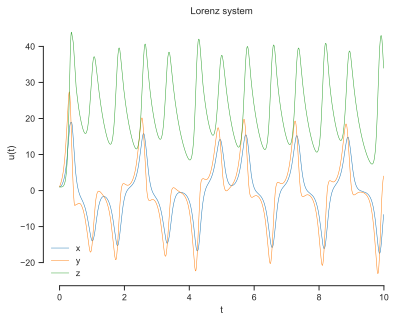

In [113]:
ts = jnp.linspace(0.0, 100.0, 10_000)
steps_to_plot = 1_000

fig, ax = plt.subplots()
ax.plot(ts[:steps_to_plot], ys[0, :steps_to_plot, 0], label="x", lw=0.5)
ax.plot(ts[:steps_to_plot], ys[0, :steps_to_plot, 1], label="y", lw=0.5)
ax.plot(ts[:steps_to_plot], ys[0, :steps_to_plot, 2], label="z", lw=0.5)
ax.legend(frameon=False)
ax.set(xlabel="t", ylabel="u(t)", title="Lorenz system")
sns.despine(trim=True)

And here is the classic butterfly plot:

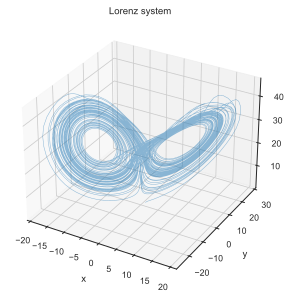

In [81]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(ys[0, :, 0], ys[0, :, 1], sol.ys[0, :, 2], lw=0.5, alpha=0.5)
ax.set(xlabel="x", ylabel="y", zlabel="z", title="Lorenz system")
sns.despine(trim=True)

Okay. Now we are going to take a tiny blob of initial conditions and see how it evolves in time.
We are going to color the points red.

In [114]:
import numpy as np

mu = np.array([1.0, 1.0, 1.0])
sigma = np.array([0.001, 0.001, 0.001])
num_samples = 1_000
u0_samples = np.random.normal(mu, sigma, size=(num_samples, 3))
ys_samples = monte_carlo_lorenz(u0_samples, theta)
ys_samples.shape


(1000, 10000, 3)

Here we go, the blob at different times:

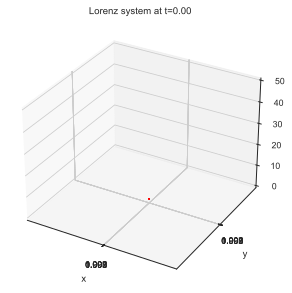

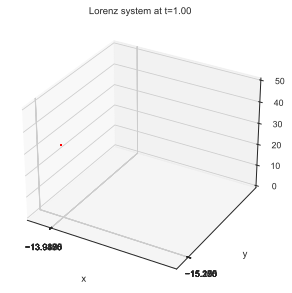

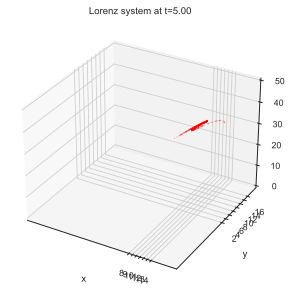

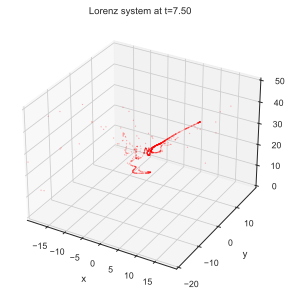

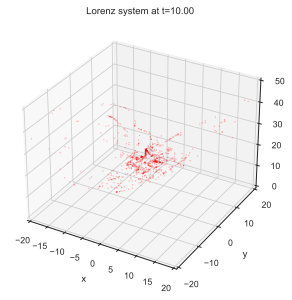

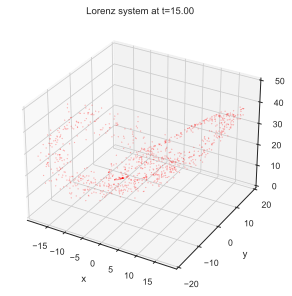

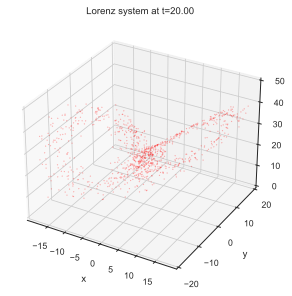

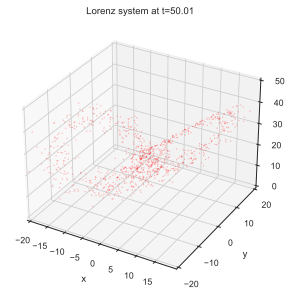

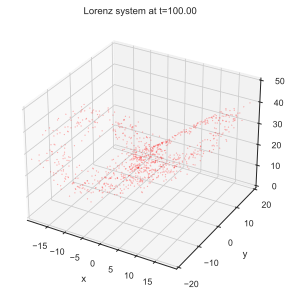

In [115]:
for i in [0, 100, 500, 750, 1_000, 1_500, 2_000, 5_000, 10_000]:
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot(ys_samples[:, i, 0], ys_samples[:, i, 1], ys_samples[:, i, 2], '.', color='red', alpha=0.5, ms=0.5)
    ax.set(xlabel="x", ylabel="y", zlabel="z", title=f"Lorenz system at t={ts[i]:.2f}")
    sns.despine(trim=True)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.set_zlim(0, 50)

You see that the tiny blob moved everywhere in the attractor.

What does this mean? We cannot predict the future of the system from the initial conditions even if we know the parameters perfectly.

We know that we will fail, but let's check where local sensitivity analysis will get us.
How far does it predict correctly?

We need to get the Jacobian with respect to the initial conditions.

In [116]:
from jax import jacobian

jit_solve_lorenz = jit(solve_lorenz)
jit_jac_solve_lorenz = jit(jacobian(solve_lorenz, argnums=0))

mu_lorenz = solve_lorenz(mu, theta)
jac_lorenz = jit_jac_solve_lorenz(mu, theta)

Here is the Jacobian.

In [117]:
jac_lorenz.shape

(10000, 3, 3)

Notice that towards the end it has quite a few NaNs:

In [118]:
jac_lorenz

Array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

       [[ 9.09877181e-01,  9.86922607e-02, -1.37051975e-04],
        [ 2.66055822e-01,  9.98531580e-01, -1.04108844e-02],
        [ 2.02484280e-02,  7.30568543e-03,  9.73287284e-01]],

       [[ 8.43284011e-01,  1.93439901e-01, -8.21596012e-04],
        [ 5.21020770e-01,  1.01683962e+00, -2.14508791e-02],
        [ 5.35953641e-02,  1.23710185e-02,  9.46779907e-01]],

       ...,

       [[            nan,             nan,             nan],
        [            nan,             nan,             nan],
        [            nan,             nan,             nan]],

       [[            nan,             nan,             nan],
        [            nan,             nan,             nan],
        [            nan,             nan,             nan]],

       [[            nan,             nan,             nan],
 

The NaNs are because of numerical errors. You may have to move to 64-bit floats to get rid of them.
Anyway, local sensitivity analysis will break before that point.
So let's proceed.
I'm only going to calculate the variance of the stochastic process - the full covariance is to big.

In [119]:
var = np.einsum(
    "tij,j,tij->ti",
    jac_lorenz,
    sigma ** 2,
    jac_lorenz
)

Again, I really hope you appreciate the magic of the `einsum` function.
Try to do the above calculation without it.

Let's look at the mean and the variance at specific times:

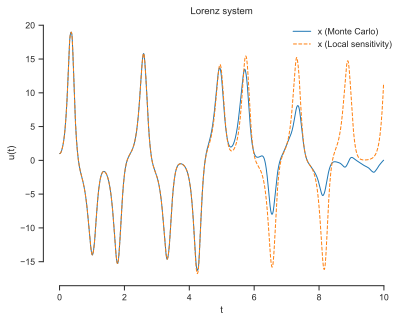

In [123]:
mc_mean = ys_samples.mean(axis=0)

fig, ax = plt.subplots()
ax.plot(ts[:steps_to_plot], mc_mean[:steps_to_plot, 0], label="x (Monte Carlo)", lw=1)
ax.plot(ts[:steps_to_plot], mu_lorenz[:steps_to_plot, 0], '--', label="x (Local sensitivity)", lw=1)
ax.set(xlabel="t", ylabel="u(t)", title="Lorenz system")
ax.legend(frameon=False)
sns.despine(trim=True)

The variance breaks down even faster:

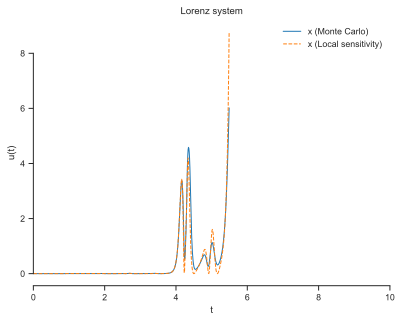

In [134]:
mc_var = ys_samples.var(axis=0)

steps_to_plot = 550
fig, ax = plt.subplots()
ax.plot(ts[:steps_to_plot], mc_var[:steps_to_plot, 0], label="x (Monte Carlo)", lw=1)
ax.plot(ts[:steps_to_plot], var[:steps_to_plot, 0], '--', label="x (Local sensitivity)", lw=1)
ax.set(xlabel="t", ylabel="u(t)", title="Lorenz system")
ax.legend(frameon=False)
ax.set_xlim(0, 10)
sns.despine(trim=True)